# Moving Averages

[Link to the Video](https://www.youtube.com/watch?v=e5PIwXnhYUo&list=PLKmQjl_R9bYd32uHImJxQSFZU5LPuXfQe&index=16)

## Intro

In my previous post we covered autoregression. This is where you forecast future values using some linear weighted combination of previous observed values of that time series. Rather than using the previous observations, we can forecast using past forecast errors instead. This is known as the moving-average (MA) model.

This is not to be confused with the rolling mean model, which is also dubbed as a moving average model.

## What is Moving Average Model?

As declared above, the moving average model is regression-like by fitting coefficients, θ, to the previously forecasted errors, ε, also known as white noise error, with the additon of a constant term that is the mean, μ:

$$
y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}
$$

This is a MA(q) model, where q is the number of error terms, which is known as the order.

### Requirements

One key requirement of the MA(q) model is that, like autoregression, it needs the data to be stationary. This is means it has a constant variance and mean through time. This can be achieved through differencing and stabilising the variance through a Logarithm or Box-Cox transform.

### Order Selection

Selecting the order of a MA model can be accomplished by viewing the autocorrelation function. Autocorrelation measures the correlation of the time series at various time steps (lags). If a lag has a high correlation, then it is influential in describing what the current value of the time series is. This idea of ‘influence’ can be used to carry out forecasts.

We can use autocorrelation to plot a correlogram of the various lags of the time series to determine which are statistically significant in impacting the forecasts. If this is hard to visualise at the moment, don't worry we will carry out a Python tutorial on this exact process later!

However, another more common approach is to simply iterate over different combinations/number of orders and use the model that gives the optimal performance. The optimal performance is typically evaluated by the model that returns the best Akaike information criterion (AIC) value, that is based on maximum likelihood estimation. This process is analogous to hyperparameter tuning in classical Machine Learning.

### Estimation

Now that we have our order of MA terms, we need to fit their coefficients! Unfortunately, this is not as easy as in linear or autoregression as the errors are not observable. So, how do we do it?

Well, it is not so straightforward. However, the general gist is that the autocorrelation values for each lag are directly related to their coefficients. Therefore, once you know the autocorrelation of a forecast error, you can work backwards to acquire its coefficient.

For example, for a MA(1) model (model with one forecast error term), its autocorrelation, c_1, is:

$$
c_1 = \frac{\theta_1}{1 + \theta_1^2}
$$

One can see that if we know c_1, then this is just a simple quadratic equation that we can solve for the coefficient. This same idea can be extended to a MA(q) model, but with more complexity of course due to multiple errors and coefficients.

In [1]:
# Import packages
import plotly.express as px
import pandas as pd

In [2]:
# Read in the data
data = pd.read_csv('../data/airline.csv')
data['Month'] = pd.to_datetime(data['Month'])

In [3]:
def plot_passenger_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the passenger data."""

    fig = px.line(df, x='Month', y=y, labels={'Month': 'Date'})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Airline Passengers',
                      width=650, title_x=0.5, height=400)

    return fig.show()

In [4]:
# Plot the airline passenger data
plot_passenger_volumes(df=data, y='#Passengers')

The time series has a clear trend and obvious yearly seasonality that is increasing through time. Therefore, we need to make it stationary by carrying out differencing and applying the Box-Cox transform:

In [5]:
# Import packages
from scipy.stats import boxcox

# Make the target stationary
data['Passengers_boxcox'], lam = boxcox(data['#Passengers'])
data["Passenger_stationary"] = data["Passengers_boxcox"].diff()
data.dropna(inplace=True)

# Plot the stationary airline passenger data
plot_passenger_volumes(df=data, y='Passenger_stationary')

The data now appears to be stationary. We could have made it further stationary by carrying out second order differencing or seasonal differencing, however I think it is satisfactory here.

###

### Modeling

We can now start the modelling phase by finding the optimal number of orders. To do this, we plot an autocorrelation correlogram like we discussed above:

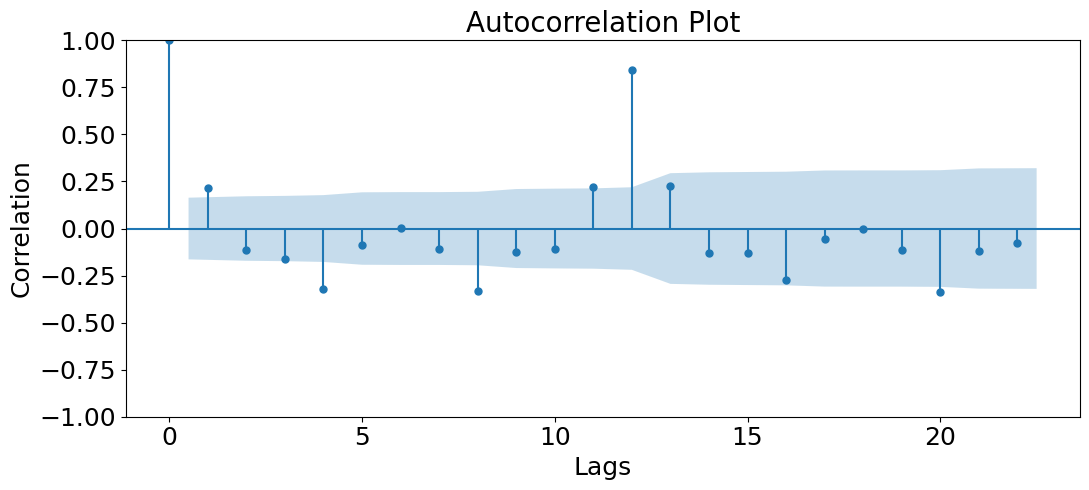

In [7]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation
plt.rc("figure", figsize=(11,5))
plot_acf(data['Passenger_stationary'])
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

The blue region signifies where the values are no longer statistically significant. From the above plot, we can that see that the last significant lag is the 13th. Therefore, our model order for the MA model will be 13. Unfortunately, no direct MA model function or package exists in Python, so we are going to use the ARIMA function from statsmodels and set every component to zero apart from the moving average orders.

In [8]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Train model
model = ARIMA(train['Passenger_stationary'], order=(0, 0, 13)).fit()

i:\Code_maths\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

i:\Code_maths\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

i:\Code_maths\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

i:\Code_maths\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

i:\Code_maths\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarnin

### Result

The forecasts produced from this fitted model is for the differenced and Box-Cox transformed time series that we produced earlier. Therefore, we have to un-difference and apply the inverse Box-Cox transform to the predictions to acquire the actual airline passenger forecasted volumes:

In [9]:
# Import packages
from scipy.special import inv_boxcox
import plotly.graph_objects as go

# Get forecasts and convert to actual passenger volumes
transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Passengers_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)


def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Moving Average Model')

i:\Code_maths\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

i:\Code_maths\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



We can see the forecasts have captured the trend mostly well, however they have failed to notice the seasonality. In my previous article, the autoregression model, that was trained on the same data, managed to pick up both the trend and seasonality.